# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries

from pyspark.sql import SparkSession
from pyspark.sql.functions import avg, col, concat, desc, explode,rand, lit, min, max, sum, split, udf, isnan, when, count, countDistinct
from pyspark.sql.types import IntegerType
from pyspark.sql.types import DateType
from pyspark.sql.window import Window
import datetime
from pyspark.sql.functions import date_format

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier,GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler, Normalizer
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.mllib.evaluation import MulticlassMetrics

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
import time

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Sparkify Project") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
# loading Dataset
sparkify_data = 'mini_sparkify_event_data.json'
df = spark.read.json(sparkify_data)

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
#Observe first row
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [6]:
# count the number of nan values in each column
df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [7]:
# count the number of null values in each column
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [8]:
# Check the number of empty values in two columns: "userId" and "sessionId"
print(df.filter(df.userId == "").count())
print(df.filter(df.sessionId == "").count())

8346
0


In [9]:
# It seems there are no sessionID missing, so we can only drop the rows with empty values in "userID"
df = df.select("*").where((df.userId != ""))
df.count()

278154

In [10]:
# Check the different options for "page" column:
df.select("page").dropDuplicates().sort("page").show()

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|              Logout|
|            NextSong|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [11]:
# Change the time format of ts and registration in the dataframe
change_time_format = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
df = df.withColumn("tsDateColumn", change_time_format(df.ts))
df = df.withColumn("registrationDateColumn", change_time_format(df.registration))

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Churn 
Churn can be defined as a metric that indicates how much a company lost in terms of revenue or clients. Detecting churn before it happens is an important task in order to implement countermeasures to avoid it, like giving additional offers to these customers. So, we must have a precise model for detecting it.
In that regard, we will create a column called "Churn", that will be defined according to the cancellation/confirmation event, which happens for both paid and free user. 

In [12]:
#Number of users in the dataset
df.select("userID").dropDuplicates().count()

225

In [13]:
#Number of user who confirmed cancellation in the dataset
df.select("userID").where(df.page == "Cancellation Confirmation").dropDuplicates().count()

52

In [14]:
#Number of users who downgraded
df.select("userID").where(df.page == "Downgrade").dropDuplicates().count()

154

Almost 70% of the costumers submitted Downgrade, so we will not consider it as a delimiter for churn. Let's focus only on the "Cancellation confirmation" event.

In [15]:
# Flag all the users who churned, based on the "Cancellation confirmation" event
churn_find = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
df = df.withColumn("churn", churn_find("page"))

# Flag all the rows for the customers who churned.
churn_window = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
df = df.withColumn("churn", max("churn").over(churn_window))

In [16]:
# checks users who churned
df.select('*').where(df.churn == 1).show(n=3)

+------+---------+---------+------+-------------+--------+------+-----+------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+----------------------+-----+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|          location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|       tsDateColumn|registrationDateColumn|churn|
+------+---------+---------+------+-------------+--------+------+-----+------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+-------------------+----------------------+-----+
|  null|Logged In|    Mason|     M|            9|    Hart|  null| free|Corpus Christi, TX|   PUT|              Cancel|1533157139000|      174|null|   307|1539318918000|"Mozilla/5.0 (Mac...|   125|2018-10-12 04:35:18|   2018-08-01 20:58:59|    1|
|  null|Cancelle

## Exploratory Data Analysis 

### Level of Subscription



In [17]:
def plot_ratio(subset, group, df = df):
    '''Plots ratio of users who churned grouped by columns
    Args: 
         subset: string of column to drop duplicates
         group: string of column to group by
         df = dataframe with data
    '''
    churn_ratio = df.drop_duplicates([subset]).groupby([group]).agg((sum("churn")/count('userId')).alias('ratio'))
    churn_ratio.show()
    churn_ratio = churn_ratio.toPandas().sort_values(by = "ratio")
    # plots proportion
    ax = churn_ratio.plot(kind='bar', figsize=(8,5), title=('Ratio of users who churned per {0}').format(group))
    ax.set_ylabel("Ratio")
    ax.set_xlabel(group)

+-----+-------------------+
|level|              ratio|
+-----+-------------------+
| free|             0.2625|
| paid|0.21379310344827587|
+-----+-------------------+



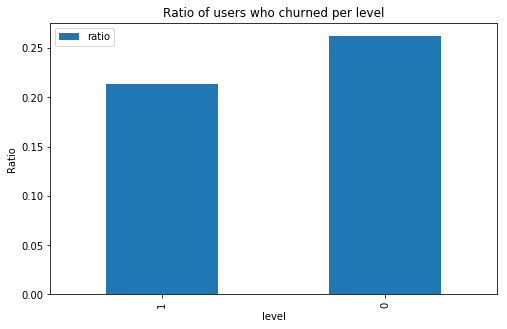

In [18]:
# finds the rate of churn in both levels of subscription (free or paid)
plot_ratio('userId', 'level')

### Gender

+------+-------------------+
|gender|              ratio|
+------+-------------------+
|     F|0.19230769230769232|
|     M| 0.2644628099173554|
+------+-------------------+



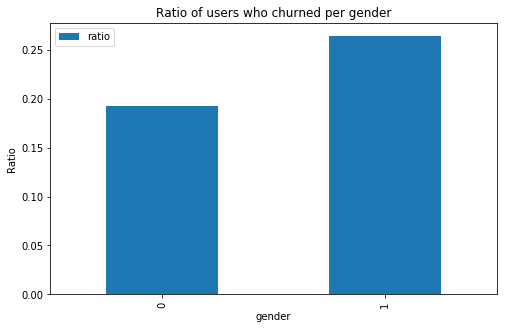

In [19]:
# finds the ratio of users who churned in both genders (male or female)
plot_ratio('userId', 'gender')

### Average number of songs played

+-----+---------------------------------------+
|churn|(count(churn) / count(DISTINCT userId))|
+-----+---------------------------------------+
|    1|                      699.8846153846154|
|    0|                     1108.1734104046243|
+-----+---------------------------------------+



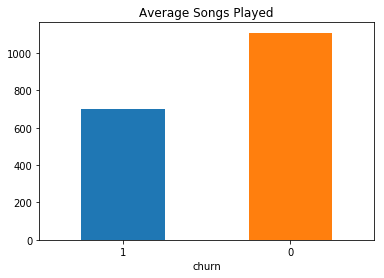

In [20]:
avg_songs_played = df.select("*").where(df.page == "NextSong").groupby("churn").agg(count("churn")/countDistinct("userId"))
avg_songs_played.show()
avg_songs_played = avg_songs_played.toPandas()
avg_songs_played.plot.bar(x='churn', y='(count(churn) / count(DISTINCT userId))', rot=0, legend= None)
plt.title('Average Songs Played');
plt.show()

### Page

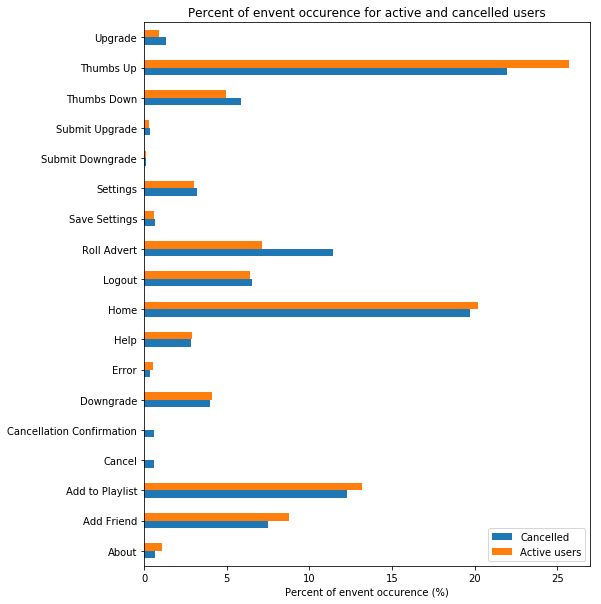

In [21]:
#find percentage in page ocurrence in cancelled and active groups
dfp = df.toPandas()
users_1 = dfp[dfp.churn == 1].groupby(['page'])['userId'].count().drop('NextSong')
users_1 = users_1 /users_1.sum()*100

users_0 = dfp[dfp.churn == 0].groupby(['page'])['userId'].count().drop('NextSong')
users_0 = users_0 /users_0.sum()*100

users_df = pd.DataFrame({'Cancelled': users_1,'Active users':users_0})
ax = users_df.plot(kind='barh', figsize=(8,10));
ax.set_xlabel('Percent of envent occurence (%)')
ax.set_title('Percent of envent occurence for active and cancelled users');

From the chart above, it seems that users who churned experienced a higher degree of exposure to Roll Advert and were more susceptible to rate a music negativelly. 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [22]:
def feature_engineering(filepath):
    '''
    Creates necessary features to train machine learning algorithms.
    First loads data set from file
    
    Resulting DF Structure:
    
    root
     |-- userId: string
     |-- downgraded: long
     |-- visited_downgrade: long
     |-- visited_cancel: long
     |-- paid: long
     |-- male: long
     |-- numSongs: int
     |-- avgThumbsUp: double
     |-- avgThumbsDown: double
     |-- numFriends: long
     |-- avgError: double
     |-- NumSession: double
     |-- avgAdvert : double
     |-- churn: long
     
    
    Args:
        filepath: path to json dataset on file
    Out:
        data: engineered dataset
    '''
    
    #dataframe with raw data 
    df = spark.read.json(filepath)
    
    #user defined functions
    churn = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
    downgrade = udf(lambda x: int(x=="Submit Downgrade"), IntegerType())
    visited_downgrade = udf(lambda x: int(x=='Downgrade'), IntegerType())
    visited_cancel = udf(lambda x: int(x=='Cancel'), IntegerType())
    days = lambda i: i * 86400 
    get_day = udf(lambda x: datetime.datetime.fromtimestamp(x/1000), DateType())
    paid = udf(lambda x: int(x=='paid'), IntegerType())
    male = udf(lambda x: int(x=='M'), IntegerType())
    
    #define windows
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    
    #select distinct users in which we will merge our results
    users_df = df.where((df.userId != "") | (df.sessionId != ""))\
        .select('userId').dropDuplicates()
    
    #downgraded: 0 or 1
    downgraded_df = df.select('userId', 'page','ts').withColumn("downgraded", downgrade("page"))
    downgraded_df = downgraded_df.withColumn("downgraded", max("downgraded").over(windowval))\
        .select('userId','downgraded').dropDuplicates(['userId']).drop('page', 'ts')
    
    #visited downgrade
    visit_down_df = df.select('userId', 'page','ts').withColumn("visited_downgrade", visited_downgrade("page"))
    visit_down_df = visit_down_df.withColumn("visited_downgrade", max("visited_downgrade").over(windowval))\
        .select('userId','visited_downgrade').dropDuplicates(['userId']).drop('page', 'ts')
    
    #visited cancel: 0 or 1
    visit_cancel_df = df.select('userId', 'page','ts').withColumn("visited_cancel", visited_cancel("page"))
    visit_cancel_df = visit_cancel_df.withColumn("visited_cancel", max("visited_cancel").over(windowval))\
        .select('userId','visited_cancel').dropDuplicates(['userId']).drop('page', 'ts')
    
    #paid : 0 or 1
    paid_df = df.select('userID', 'level')\
      .dropDuplicates(['userId']).withColumn('paid', paid("level")).drop('level')
    
    #male : 0 or 1
    male_df = df.select('userID', 'gender')\
        .dropDuplicates(['userId']).withColumn('Male', male("gender")).drop('gender')
    
    #number of songs played: int
    songs_df = df.filter(df.page=='NextSong')\
        .select('userId', 'page')\
        .groupBy('userId').count().withColumnRenamed('count', 'numSongs').drop('page')
    
    #average thumbs up: float
    avgThumbsUp = df.filter(df.page=='Thumbs Up')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean().withColumnRenamed('avg(count(page))', 'avgThumbsUp').drop('page', 'date', 'ts')
    
    #average thumbs down
    avgThumbsDown = df.filter(df.page=='Thumbs Down')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'})\
        .groupBy('userId').mean()\
        .withColumnRenamed('avg(count(page))', 'avgThumbsDown').drop('page', 'date', 'ts')
    
    #number of friends
    numFriends = df.filter(df.page=='Add Friend')\
        .select('userId', 'page')\
        .groupBy('userId').count().withColumnRenamed('count', 'numFriends').drop('page')
    
    # daily errors
    errors_df = df.filter(df.page=='Error')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean().withColumnRenamed('avg(count(page))', 'avgError').drop('page', 'date', 'ts')
    
    #daily roll advert 
    advert_df = df.filter(df.page=='Roll Advert')\
        .select('userId', 'page', 'ts')\
        .withColumn('date', get_day(col('ts')))\
        .groupBy('userId', 'date').agg({'page':'count'}).groupBy('userId')\
        .mean().withColumnRenamed('avg(count(page))', 'avgAdvert').drop('page', 'date', 'ts')
    
    #number of sessions
    num_sessions_df = df.select('userId', 'sessionId')\
        .dropDuplicates().groupby('userId')\
        .count().withColumnRenamed('count', 'numSession').drop('sessionId')
    
    #churn
    label_df = df.select('userId', 'page','ts').withColumn("label", churn("page"))
    label_df = label_df.withColumn("label", max("label").over(windowval))\
        .select('userId','label').dropDuplicates(['userId']).drop('page', 'ts')
    
    #joining all
    data = users_df.join(downgraded_df,'userId')\
    .join(visit_down_df,'userId')\
    .join(visit_cancel_df, 'userId')\
    .join(paid_df, 'userId')\
    .join(male_df, 'userId')\
    .join(songs_df, 'userId')\
    .join(avgThumbsUp, 'userId')\
    .join(avgThumbsDown, 'userId')\
    .join(numFriends, 'userId')\
    .join(errors_df, 'userId')\
    .join(advert_df, 'userId')\
    .join(num_sessions_df, 'userId')\
    .join(label_df, 'userId')

    
    return data    

In [23]:
new_features = feature_engineering("mini_sparkify_event_data.json")

In [24]:
new_features.show()

+------+----------+-----------------+--------------+----+----+--------+------------------+------------------+----------+------------------+------------------+----------+-----+
|userId|downgraded|visited_downgrade|visited_cancel|paid|Male|numSongs|       avgThumbsUp|     avgThumbsDown|numFriends|          avgError|         avgAdvert|numSession|label|
+------+----------+-----------------+--------------+----+----+--------+------------------+------------------+----------+------------------+------------------+----------+-----+
|   124|         0|                0|             0|   1|   0|    4079| 5.896551724137931|1.8636363636363635|        74|               1.2|               1.0|        29|    0|
|     7|         0|                0|             0|   0|   1|     150|              1.75|               1.0|         1|               1.0|               3.2|         7|    0|
|    15|         0|                0|             0|   1|   1|    1914|               5.4|               1.4|        31|

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

### Transform into Vector and Normalize

In [25]:
#create VectorAssembler to push data to ML models
assembler = VectorAssembler(inputCols=["downgraded","visited_downgrade","visited_cancel","paid",\
                                       "Male","numSongs","avgThumbsUp","avgThumbsDown","numFriends","avgError",\
                                       "numSession", "avgAdvert"],\
                            outputCol="inputFeatures")

#Normalize Data
scaler = Normalizer(inputCol="inputFeatures", outputCol="ScaledFeatures")

In [26]:
#create classifiers objects
clf_LR = LogisticRegression(featuresCol="ScaledFeatures", labelCol="label", maxIter=10, regParam=0.01)
clf_RF = RandomForestClassifier(featuresCol="ScaledFeatures", labelCol="label")
clf_DT = DecisionTreeClassifier(featuresCol="ScaledFeatures", labelCol="label")
clf_GBT = GBTClassifier(featuresCol="ScaledFeatures", labelCol="label")

In [27]:
#Create Pipeline with transformers and estimators
pipeline_lr = Pipeline(stages=[assembler, scaler, clf_LR])
pipeline_rf = Pipeline(stages=[assembler, scaler, clf_RF])
pipeline_dt = Pipeline(stages=[assembler, scaler, clf_DT])
pipeline_gbt = Pipeline(stages=[assembler, scaler, clf_GBT])

### Split full dataset into train/test sets

In [28]:
train, test = new_features.randomSplit([0.7, 0.3], seed=7)

### Train ML models

In [29]:
#Fit train data to models and print execution time

start_time= time.time()

model_lr_fitted = pipeline_lr.fit(train)
lr_time = time.time()
print("Execution time to train the Logistic Regression Model:{}".format(lr_time-start_time))
model_rf_fitted = pipeline_rf.fit(train)
rf_time = time.time()
print("Execution time to train the Random Forest Model:{}".format(rf_time-lr_time))
model_dt_fitted = pipeline_rf.fit(train)
dt_time = time.time()
print("Execution time to train the Decision Tree Model:{}".format(dt_time-rf_time))
model_gbt_fitted = pipeline_gbt.fit(train)
gbt_time = time.time()
print("Execution time to train the GBT Model:{}".format(gbt_time-dt_time))

end_time= time.time()

print("Total execution time:{}".format(end_time-start_time))

Execution time to train the Logistic Regression Model:145.91924953460693
Execution time to train the Random Forest Model:175.97855973243713
Execution time to train the Decision Tree Model:171.97584342956543
Execution time to train the GBT Model:366.16128754615784
Total execution time:860.0355205535889


In [30]:
#Calculate performance metric
def model_performance(model, test_set, metric):
    """ Calculate Model Scores using f1 metric 
        Input: 
            model- trained model or pipeline object
            metric- the metric used to measure performance
            data - data on which performance measurement should be done
        Output:
            score
    """
    evaluator = MulticlassClassificationEvaluator(metricName = metric)
    prediction_result = model.transform(test_set)
    # find f1 score
    score = evaluator.evaluate(prediction_result)
    #return score
    return score

In [31]:
#print models accuracy
print("Logistic Regression Classifier Accuracy:{}".format(model_performance(model_lr_fitted, test, "accuracy")))
print("Random Forest Classifier Accuracy:{}".format(model_performance(model_rf_fitted, test, "accuracy")))
print("Decision Tree Classifier Accuracy:{}".format(model_performance(model_dt_fitted,test,"accuracy")))
print("GBTClassifier Classifier Accuracy:{}".format(model_performance(model_gbt_fitted,test,"accuracy")))

Logistic Regression Classifier Accuracy:0.8571428571428571
Random Forest Classifier Accuracy:0.7714285714285715
Decision Tree Classifier Accuracy:0.7714285714285715
GBTClassifier Classifier Accuracy:0.7142857142857143


In [32]:
#print models f1 score
print("Logistic Regression Classifier f1-score:{}".format(model_performance(model_lr_fitted, test, "f1")))
print("Random Forest Classifier f1-score:{}".format(model_performance(model_rf_fitted, test, "f1")))
print("Decision Tree Classifier f1-score:{}".format(model_performance(model_dt_fitted,test, "f1")))
print("GBTClassifier Classifier f1-score:{}".format(model_performance(model_gbt_fitted,test,"f1")))

Logistic Regression Classifier f1-score:0.7912087912087912
Random Forest Classifier f1-score:0.7465437788018434
Decision Tree Classifier f1-score:0.7465437788018434
GBTClassifier Classifier f1-score:0.7142857142857143


As we can see above, the logistic regression is the best model until now on this project with a f1-score of almost 80%.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.